<a href="https://colab.research.google.com/github/supriyag123/PHD_Pub/blob/main/AGENTIC-MODULE4-Sensor-Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading data...

=== 0 → 1 → 2 progression inside TEST subset ===
First 0 in TEST: 0
First 1 after that in TEST: 200
First 2 after that in TEST: 926

Within TEST, you need the first 927 contiguous TEST windows (test indices 0..926) to cover one 0→1→2 progression.
✅ Loaded TEST subsequences: (280283, 100, 12)
🚀 Creating robust system with 12 sensors
✅ AE model loaded for sensor 0
✅ AE model loaded for sensor 1
✅ AE model loaded for sensor 2
✅ AE model loaded for sensor 3
✅ AE model loaded for sensor 4
✅ AE model loaded for sensor 5
✅ AE model loaded for sensor 6
✅ AE model loaded for sensor 7
✅ AE model loaded for sensor 8
✅ AE model loaded for sensor 9
✅ AE model loaded for sensor 10
✅ AE model loaded for sensor 11
✅ Created system: 12/12 models loaded
▶️ Streaming evaluation on 1000 samples



Step 1/1000
Label=0 (bin=0)
System: {'system_anomaly': True, 'system_drift': False, 'system_needs_retrain': False, 'anomaly_rate': 0.5833333333333334, 'drift_rate': 0.0, 'retrain_rate': 0.0}

Step 2/1000
Label=0 (bin=0)
System: {'system_anomaly': False, 'system_drift': False, 'system_needs_retrain': False, 'anomaly_rate': 0.0, 'drift_rate': 0.0, 'retrain_rate': 0.0}

Step 3/1000
Label=0 (bin=0)
System: {'system_anomaly': False, 'system_drift': False, 'system_needs_retrain': False, 'anomaly_rate': 0.0, 'drift_rate': 0.0, 'retrain_rate': 0.0}

Step 4/1000
Label=0 (bin=0)
System: {'system_anomaly': False, 'system_drift': False, 'system_needs_retrain': False, 'anomaly_rate': 0.0, 'drift_rate': 0.0, 'retrain_rate': 0.0}

Step 5/1000
Label=0 (bin=0)
System: {'system_anomaly': False, 'system_drift': False, 'system_needs_retrain': False, 'anomaly_rate': 0.0, 'drift_rate': 0.0, 'retrain_rate': 0.0}

Step 6/1000
Label=0 (bin=0)
System: {'system_anomaly': False, 'system_drift': False, 'system_ne

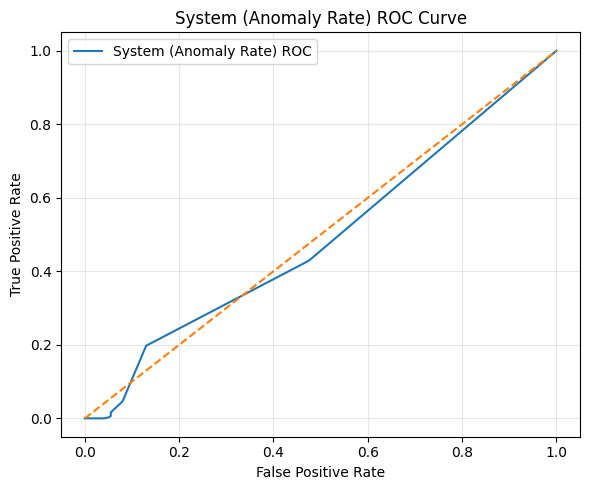

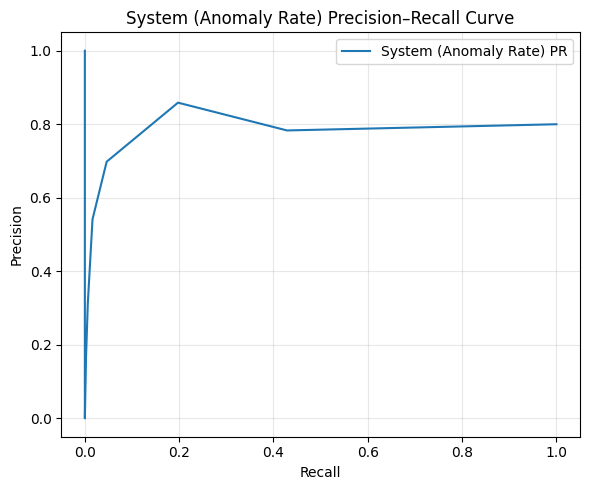


================ PER-SENSOR EVALUATION ================

----- Sensor 0 -----
Confusion Matrix (0=Normal, 1=Fault):
[[180  20]
 [741  59]]
Classification Report:
              precision    recall  f1-score   support

      Normal      0.195     0.900     0.321       200
       Fault      0.747     0.074     0.134       800

    accuracy                          0.239      1000
   macro avg      0.471     0.487     0.228      1000
weighted avg      0.637     0.239     0.172      1000

Sensor 0 ROC AUC: 0.347
Sensor 0 PR  AUC: 0.703

----- Sensor 1 -----
Confusion Matrix (0=Normal, 1=Fault):
[[181  19]
 [752  48]]
Classification Report:
              precision    recall  f1-score   support

      Normal      0.194     0.905     0.320       200
       Fault      0.716     0.060     0.111       800

    accuracy                          0.229      1000
   macro avg      0.455     0.483     0.215      1000
weighted avg      0.612     0.229     0.152      1000

Sensor 1 ROC AUC: 0.234
Senso

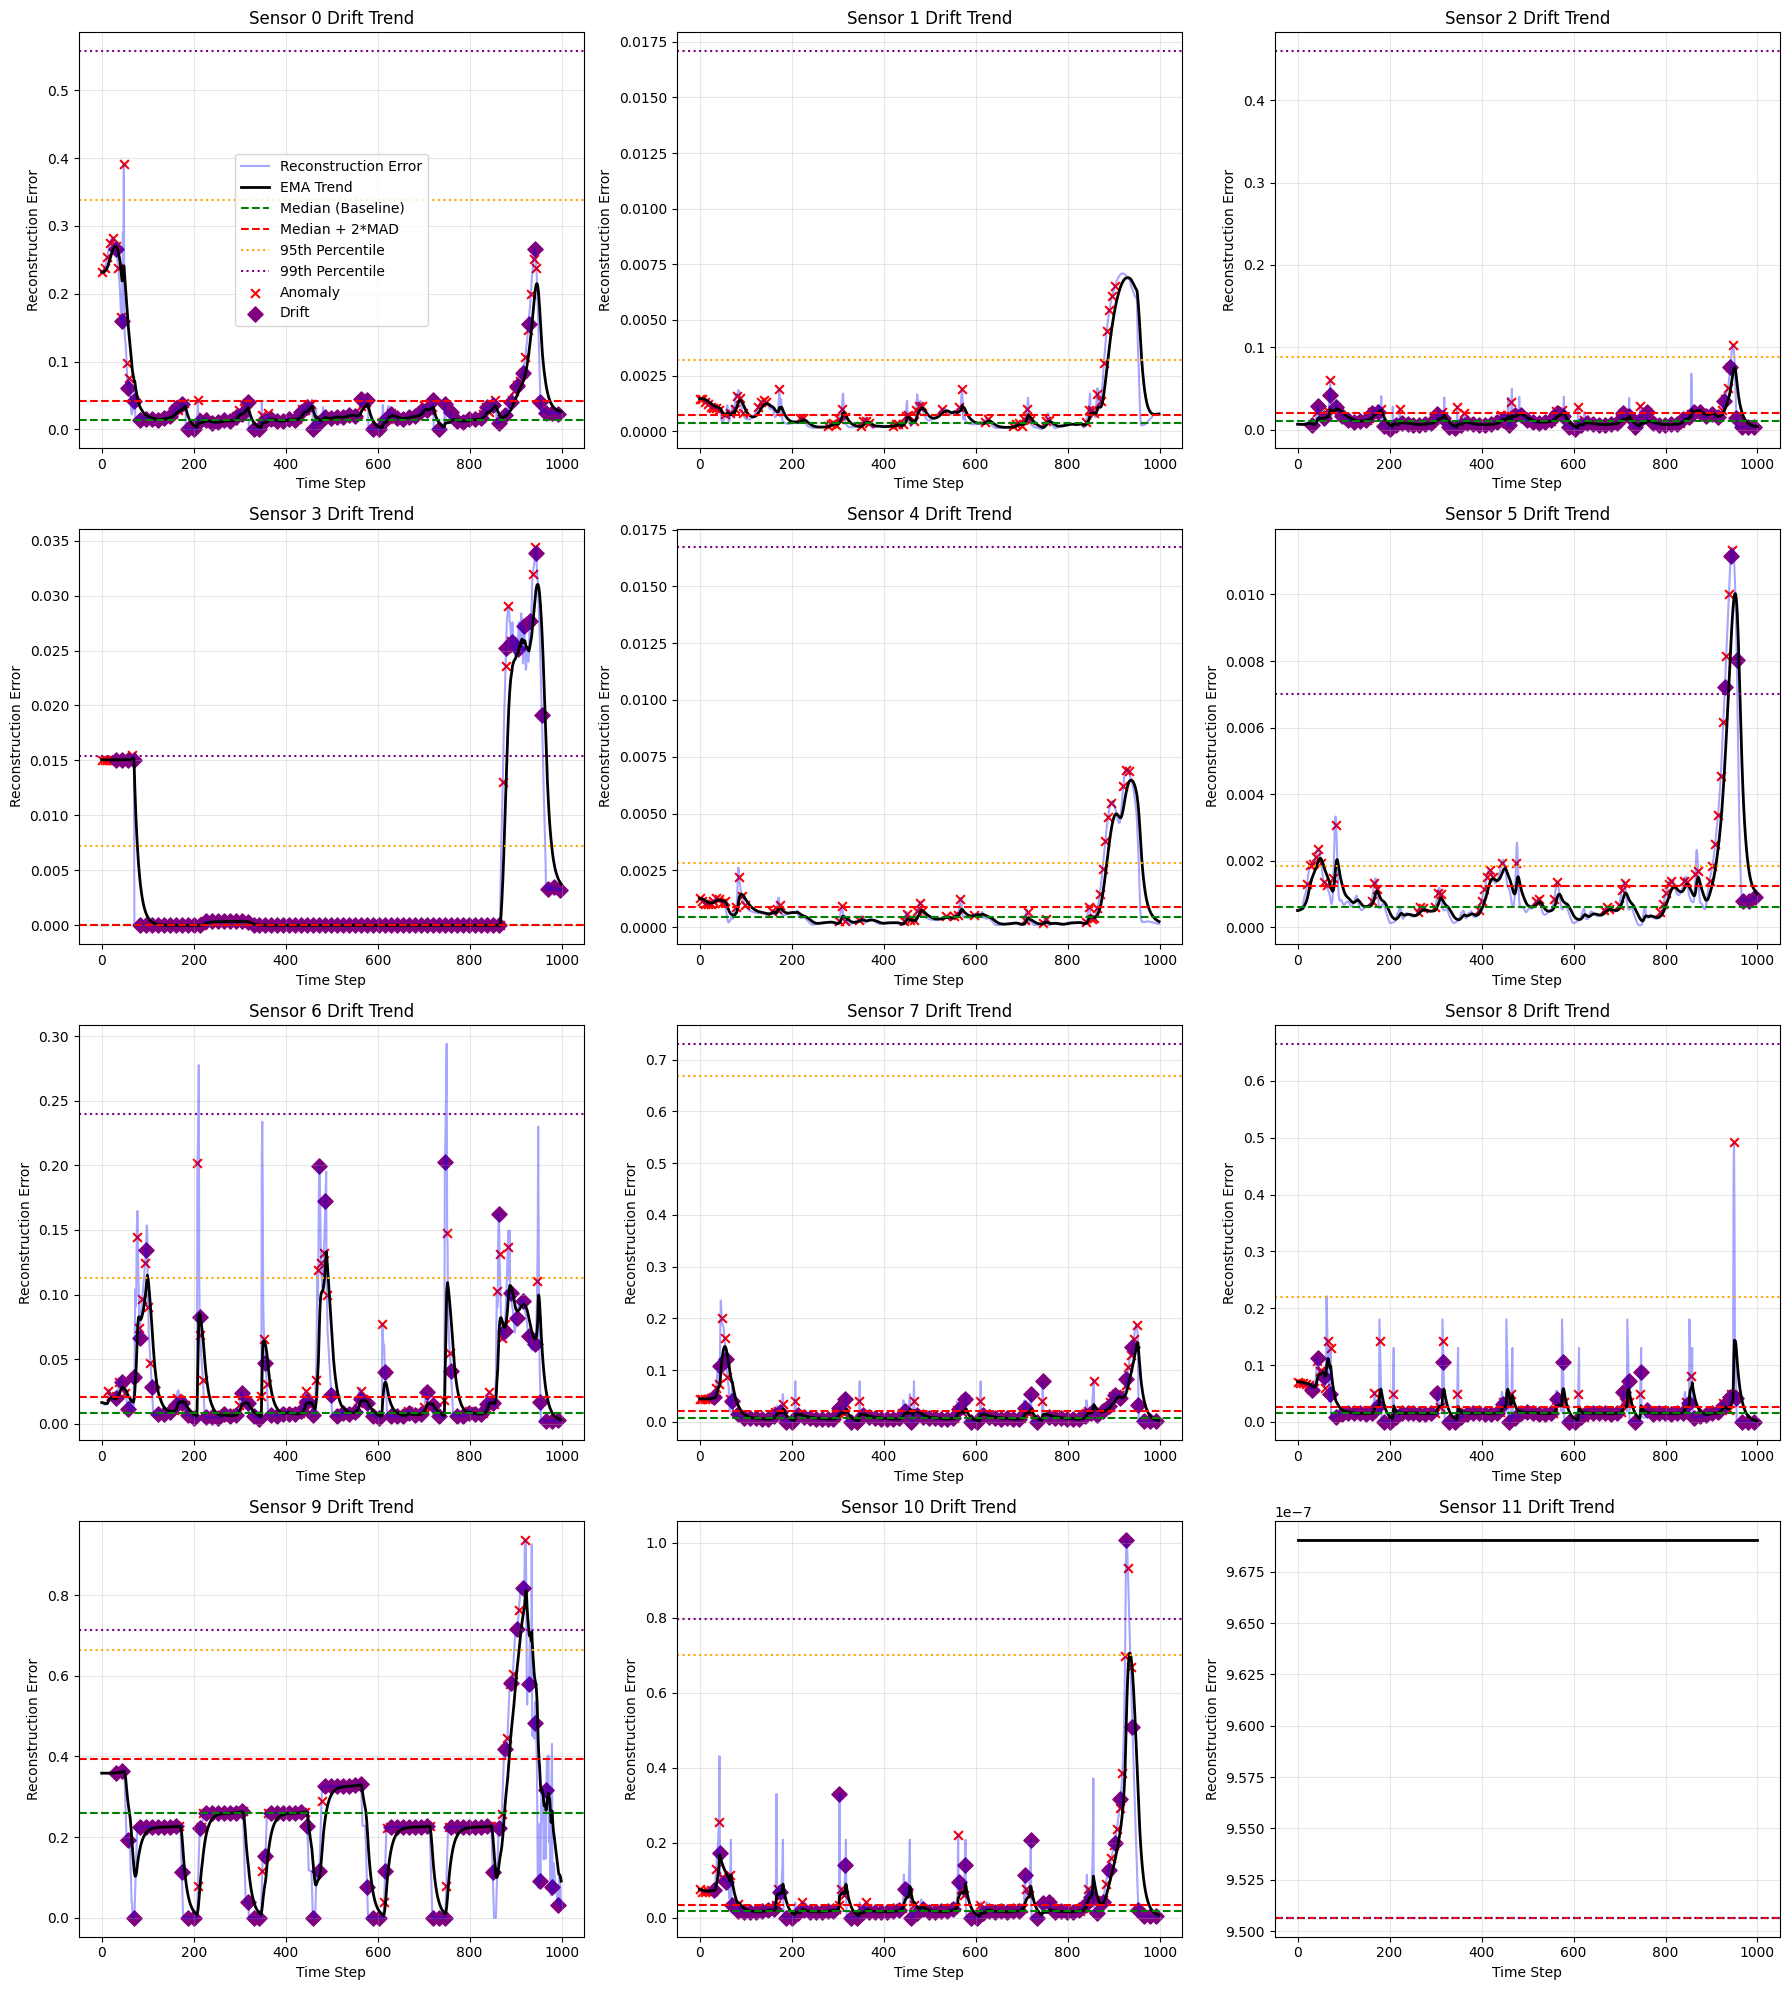


=================== MULTI-CLASS CONFUSION MATRIX (0,1,2) ===================


ValueError: Found input variables with inconsistent numbers of samples: [280283, 1000]

In [8]:
import numpy as np
import pickle
import os
from collections import deque
from datetime import datetime
from typing import Dict, List, Tuple
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from scipy import stats
from scipy.spatial.distance import jensenshannon

# Deep learning
try:
    from tensorflow.keras.models import load_model
    KERAS_AVAILABLE = True
except ImportError:
    KERAS_AVAILABLE = False

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
    roc_curve
)

# =====================================================
# ROBUST SENSOR AGENT - Observes ONE sensor with AE model
# =====================================================

class RobustSensorAgent:
    """
    Robust Sensor Agent for ONE sensor with advanced anomaly & drift detection.

    Loads pretrained AE model + metadata (scaler, baseline errors, rolling stats).
    Computes anomaly score via reconstruction error, applies adaptive thresholding,
    drift detection, and outputs robust anomaly/drift/retrain flags.
    """

    def __init__(self,
                 sensor_id: int,
                 model_path: str = None,
                 window_length: int = 10, #K
                 memory_size: int = 1000,
                 threshold_k: float = 2.0,
                 drift_threshold: float = 0.1,
                warmup_steps: int = 100):    # <── NEW PARAM

        self.sensor_id = sensor_id
        self.window_length = window_length
        self.threshold_k = threshold_k
        self.drift_threshold = drift_threshold
        self.warmup_steps = warmup_steps

        # Model & metadata
        self.model = None
        self.scaler = None
        self.is_model_loaded = False

        # Buffers
        self.error_memory = deque(maxlen=memory_size)
        self.data_memory = deque(maxlen=memory_size)
        self.recent_errors = deque(maxlen=100)

        # Rolling stats
        self.rolling_stats = {
            'median': 0.0,
            'mad': 1.0,
            'mean': 0.0,   # backward compatibility
            'std': 1.0,    # backward compatibility
            'q95': 0.0,
            'q99': 0.0
        }
        self.baseline_errors = None

        # Counters
        self.total_processed = 0
        self.anomalies_detected = 0
        self.drift_detected_count = 0
        self.last_stats_update = datetime.now()

        self.anomaly_cooldown = 0
        self.drift_cooldown = 0

        self.anomaly_cooldown_steps = 5    # you can tune
        self.drift_cooldown_steps = 10     # you can tune

        self.consecutive_drift_votes = 0
        self.consecutive_anomaly_votes = 0

        if model_path:
            self.load_model(model_path)

    def load_model(self, model_path: str) -> bool:
        """Load pretrained AE model + metadata."""
        try:
            if KERAS_AVAILABLE and model_path.endswith('.h5'):
                self.model = load_model(model_path, compile=False)

                # Correct metadata file
                metadata_path = model_path.replace('_model.h5', '_metadata.pkl')

                if os.path.exists(metadata_path):
                    with open(metadata_path, 'rb') as f:
                        metadata = pickle.load(f)

                    baseline = metadata.get('baseline_stats', None)

                    if baseline is not None:
                        # Initialize rolling stats from training
                        # Load robust baseline stats
                        self.rolling_stats['median'] = baseline.get('median')
                        self.rolling_stats['mad']    = baseline.get('mad')

                        # Backward compatibility for other parts of system
                        self.rolling_stats['mean'] = self.rolling_stats['median']
                        self.rolling_stats['std']  = self.rolling_stats['mad']

                        self.rolling_stats['q95']  = baseline['q95']
                        self.rolling_stats['q99']  = baseline['q99']

                        # Save baseline distribution for drift detection
                        self.baseline_errors = np.array(baseline['baseline_errors'])

                # AE was trained on raw, NOT scaled
                self.scaler = None

            else:
                raise ValueError("Unsupported model format – expecting .h5 AE model")

            self.is_model_loaded = True
            print(f"✅ AE model loaded for sensor {self.sensor_id}")
            return True

        except Exception as e:
            print(f"❌ Failed to load AE model for sensor {self.sensor_id}: {e}")
            return False


    def observe(self, sensor_subsequence: np.ndarray) -> Dict:
        """Observe subsequence [window_length] and return anomaly/drift flags."""
        if not self.is_model_loaded:
            return {"sensor_id": self.sensor_id, "error": "no_model_loaded", "timestamp": datetime.now()}

        if len(sensor_subsequence) != self.window_length:
            return {"sensor_id": self.sensor_id,
                    "error": f"invalid_length_expected_{self.window_length}_got_{len(sensor_subsequence)}",
                    "timestamp": datetime.now()}

        # 1. Anomaly score
        anomaly_score = self._compute_robust_anomaly_score(sensor_subsequence)

        # 2. Update memory
        self.data_memory.append(sensor_subsequence.copy())
        self.error_memory.append(anomaly_score)
        self.recent_errors.append(anomaly_score)

        # 3

        # --------------- WARM-UP PHASE -----------------
        # During warm-up, rolling stats ignore live data and stay fixed
        if self.total_processed < self.warmup_steps:
            med = np.median(self.baseline_errors)
            mad = np.median(np.abs(self.baseline_errors - med)) + 1e-8

            self.rolling_stats['median'] = med
            self.rolling_stats['mad'] = mad
            self.rolling_stats['mean'] = med     # backward compatibility
            self.rolling_stats['std'] = mad
        else:
            # After warm-up, rolling stats evolve normally
            if len(self.error_memory) >= 50 and len(self.error_memory) % 10 == 0:
                self._update_rolling_stats(list(self.error_memory)[-50:])

        # 4. Flags
        is_anomaly = self._check_adaptive_anomaly(anomaly_score)
        drift_flag = self._check_advanced_drift()
        needs_retrain = self._check_retrain_need()
        confidence = self._compute_robust_confidence(anomaly_score)

        # 5. Update counters
        self.total_processed += 1
        if is_anomaly: self.anomalies_detected += 1
        if drift_flag: self.drift_detected_count += 1

        return {
            "sensor_id": self.sensor_id,
            "timestamp": datetime.now(),
            "is_anomaly": bool(is_anomaly),
            "drift_flag": bool(drift_flag),
            "needs_retrain_flag": bool(needs_retrain),
            "anomaly_score": float(anomaly_score),
            "confidence": float(confidence),
            "threshold_used": float(self.rolling_stats['median'] + self.threshold_k * self.rolling_stats['mad']),
            "anomaly_rate": self.anomalies_detected / max(1, self.total_processed),
            "drift_rate": self.drift_detected_count / max(1, self.total_processed)
        }

    def _compute_robust_anomaly_score(self, subsequence: np.ndarray) -> float:
        """Compute reconstruction error using AE model on RAW values."""
        try:
            # Ensure shape: [1, window_length, 1]
            X = subsequence.reshape(1, self.window_length, 1)
            reconstruction = self.model.predict(X, verbose=0)

            error = mean_squared_error(
                subsequence.flatten(),
                reconstruction.flatten()
            )
            return max(0.0, error)

        except Exception as e:
            print(f"⚠️ AE inference failed for sensor {self.sensor_id}: {e}")
            # Fallback: variance of raw subsequence
            return float(np.var(subsequence))

    def _update_rolling_stats(self, errors: List[float]):
        errors_array = np.array(errors)

        median = np.median(errors_array)
        mad = np.median(np.abs(errors_array - median)) + 1e-8  # avoid zero

        # Store
        self.rolling_stats['median'] = median
        self.rolling_stats['mad'] = mad

        # Backward compatibility fields (for plotting)
        self.rolling_stats['mean'] = median
        self.rolling_stats['std'] = mad

        # Percentile bands (unchanged; good for drift & visualization)
        self.rolling_stats['q95'] = np.percentile(errors_array, 95)
        self.rolling_stats['q99'] = np.percentile(errors_array, 99)

        self.last_stats_update = datetime.now()

    def _check_adaptive_anomaly(self, score: float) -> bool:
        median = self.rolling_stats.get('median', self.rolling_stats['mean'])
        mad = self.rolling_stats.get('mad', self.rolling_stats['std'])
        threshold = median + self.threshold_k * mad
        is_anomaly_now = score > threshold

        # Cooldown active → suppress anomaly
        if self.anomaly_cooldown > 0:
            self.anomaly_cooldown -= 1
            return False

        # No cooldown and anomaly happened → activate cooldown
        if is_anomaly_now:
            self.anomaly_cooldown = self.anomaly_cooldown_steps
            return True

        return False

    def _check_advanced_drift(self) -> bool:
        if self.baseline_errors is None or len(self.recent_errors) < 30:
            return False
        try:
            hist_baseline, bins = np.histogram(self.baseline_errors, bins=20, density=True)
            hist_recent, _ = np.histogram(list(self.recent_errors), bins=bins, density=True)
            hist_baseline += 1e-10; hist_recent += 1e-10
            hist_baseline /= hist_baseline.sum(); hist_recent /= hist_recent.sum()
            js_divergence = jensenshannon(hist_baseline, hist_recent)
            is_drift_now = js_divergence > self.drift_threshold

            # Cooldown active → suppress
            if self.drift_cooldown > 0:
                self.drift_cooldown -= 1
                return False

            # Multi-step confirmation: require 3 drift votes in last few steps
            if is_drift_now:
                self.consecutive_drift_votes += 1
            else:
                self.consecutive_drift_votes = 0

            if self.consecutive_drift_votes >= 3:
                self.drift_cooldown = self.drift_cooldown_steps
                self.consecutive_drift_votes = 0
                return True

            return False

        except Exception:
            try:
                _, p_value = stats.ks_2samp(self.baseline_errors, list(self.recent_errors))
                return p_value < 0.05
            except:
                return False

    def _check_retrain_need(self) -> bool:
        if len(self.error_memory) < 100: return False
        recent_errors = list(self.error_memory)[-50:]
        threshold = self.rolling_stats['mean'] + self.threshold_k * self.rolling_stats['std']
        anomaly_rate = sum(1 for e in recent_errors if e > threshold) / len(recent_errors)
        criteria = [
            anomaly_rate > 0.3,
            self.drift_detected_count > 0.1 * self.total_processed,
            np.mean(recent_errors) > 2.0 * self.rolling_stats['mean'] if len(recent_errors) > 0 else False,
            (datetime.now() - self.last_stats_update).days > 7
        ]
        return sum(criteria) >= 2

    def _compute_robust_confidence(self, score: float) -> float:
        median = self.rolling_stats.get('median')
        mad = self.rolling_stats.get('mad')

        if mad == 0:
            return 0.5

        threshold = median + self.threshold_k * mad

        z = (score - threshold) / mad  # how far beyond threshold?

        # Smooth probability-like mapping
        confidence = 1 / (1 + np.exp(-z))

        return float(np.clip(confidence, 0.0, 1.0))



# =====================================================
# ROBUST MASTER AGENT
# =====================================================

class RobustMasterAgent:
    """Aggregates sensor results, makes system-level anomaly/drift/retrain decisions."""
    def __init__(self, sensor_agents: List[RobustSensorAgent],
                 system_anomaly_threshold: float = 0.3,
                 drift_threshold: float = 0.2,
                 retrain_threshold: float = 0.15):
        self.sensor_agents = sensor_agents
        self.num_sensors = len(sensor_agents)
        self.system_anomaly_threshold = system_anomaly_threshold
        self.drift_threshold = drift_threshold
        self.retrain_threshold = retrain_threshold

    def process_system_input(self, system_subsequence: np.ndarray) -> Dict:
        """Process [window_length, num_sensors] multivariate subsequence."""
        timestamp = datetime.now()
        if system_subsequence.shape[1] != self.num_sensors:
            return {"error": f"Expected {self.num_sensors} sensors, got {system_subsequence.shape[1]}",
                    "timestamp": timestamp}

        # 1. Collect sensor observations
        sensor_results = []
        for i, agent in enumerate(self.sensor_agents):
            sensor_data = system_subsequence[:, i]
            result = agent.observe(sensor_data)
            sensor_results.append(result)

        # 2. Simple aggregation
        anomalies = sum(1 for r in sensor_results if r.get("is_anomaly"))
        drifts = sum(1 for r in sensor_results if r.get("drift_flag"))
        retrains = sum(1 for r in sensor_results if r.get("needs_retrain_flag"))

        anomaly_rate = anomalies / max(1, self.num_sensors)
        drift_rate = drifts / max(1, self.num_sensors)
        retrain_rate = retrains / max(1, self.num_sensors)

        system_decisions = {
            "system_anomaly": anomaly_rate >= self.system_anomaly_threshold,
            "system_drift": drift_rate >= self.drift_threshold,
            "system_needs_retrain": retrain_rate >= self.retrain_threshold,
            "anomaly_rate": anomaly_rate,
            "drift_rate": drift_rate,
            "retrain_rate": retrain_rate
        }

        return {
            "timestamp": timestamp,
            "sensor_results": sensor_results,
            "system_decisions": system_decisions
        }


# =====================================================
# SYSTEM CREATION
# =====================================================

def create_robust_system(num_sensors: int, models_dir: str, win_length: int, warmup_steps: int = 100) -> Tuple[List[RobustSensorAgent], RobustMasterAgent]:
    """Create robust sensor system loading AE models + metadata."""
    print(f"🚀 Creating robust system with {num_sensors} sensors")
    sensor_agents = []
    for sensor_id in range(num_sensors):
        model_path = os.path.join(models_dir, f"sensor_{sensor_id}_model.h5")
        agent = RobustSensorAgent(sensor_id=sensor_id,
                                  model_path=model_path if os.path.exists(model_path) else None,
                                  window_length=win_length,
                                  memory_size=1000,
                                  threshold_k=2.0,
                                  drift_threshold=0.1,
                                  warmup_steps=warmup_steps)       # <── NEW
        sensor_agents.append(agent)

    master = RobustMasterAgent(sensor_agents=sensor_agents,
                               system_anomaly_threshold=0.3,
                               drift_threshold=0.2,
                               retrain_threshold=0.15)
    print(f"✅ Created system: {len([a for a in sensor_agents if a.is_model_loaded])}/{num_sensors} models loaded")

    return sensor_agents, master



import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_sensor_drift_trends(sensor_logs, metadata_list, window_size=20):
    """
    Plot reconstruction error and drift/anomaly markers for each sensor.
    Uses robust baselines: median + MAD.
    """

    num_sensors = len(sensor_logs)
    cols = 3
    rows = int(np.ceil(num_sensors / cols))

    plt.figure(figsize=(18, 5 * rows))

    for sid, log in enumerate(sensor_logs):

        scores    = np.array(log["scores"])
        anomalies = np.array(log["anomalies"])
        drift     = np.array(log["drift"])

        # --- Extract robust baseline stats ---
        median = metadata_list[sid].get("median", metadata_list[sid].get("mean", 0))
        mad    = metadata_list[sid].get("mad", metadata_list[sid].get("std", 1))
        q95    = metadata_list[sid].get("q95", 0)
        q99    = metadata_list[sid].get("q99", 0)

        threshold = median + 2 * mad

        ema = pd.Series(scores).ewm(span=window_size, adjust=False).mean()

        ax = plt.subplot(rows, cols, sid + 1)

        # --- Raw reconstruction error ---
        ax.plot(scores, color="blue", alpha=0.35, label="Reconstruction Error")

        # --- EMA trend ---
        ax.plot(ema, color="black", linewidth=2, label="EMA Trend")

        # --- Robust baseline lines ---
        ax.axhline(median, color="green", linestyle="--", label="Median (Baseline)")
        ax.axhline(threshold, color="red", linestyle="--", label="Median + 2*MAD")
        ax.axhline(q95, color="orange", linestyle=":", label="95th Percentile")
        ax.axhline(q99, color="purple", linestyle=":", label="99th Percentile")

        # --- Mark anomalies ---
        anomaly_idx = np.where(anomalies == 1)[0]
        ax.scatter(anomaly_idx, scores[anomaly_idx], color="red", s=40,
                   marker="x", label="Anomaly" if sid == 0 else "")

        # --- Mark drifts ---
        drift_idx = np.where(drift == 1)[0]
        ax.scatter(drift_idx, scores[drift_idx], color="purple", s=60,
                   marker="D", label="Drift" if sid == 0 else "")

        ax.set_title(f"Sensor {sid} Drift Trend", fontsize=12)
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Reconstruction Error")
        ax.grid(alpha=0.3)

        if sid == 0:
            ax.legend()

    plt.tight_layout()
    plt.show()



def evaluate_system_level(y_true_bin, y_pred_bin, y_scores, title_prefix="System"):
    """
    y_true_bin : list/array of 0/1 (0=normal, 1=fault)
    y_pred_bin : list/array of 0/1 from your system_anomaly
    y_scores   : list/array of continuous scores (e.g., anomaly_rate or max score)
    """

    y_true_bin = np.array(y_true_bin)
    y_pred_bin = np.array(y_pred_bin)
    y_scores   = np.array(y_scores)

    print(f"\n========== {title_prefix} – Confusion Matrix ==========")
    cm = confusion_matrix(y_true_bin, y_pred_bin, labels=[0, 1])
    print("Labels: 0=Normal, 1=Fault")
    print(cm)

    print(f"\n========== {title_prefix} – Classification Report ==========")
    print(classification_report(y_true_bin, y_pred_bin, target_names=["Normal", "Fault"], digits=3))

    # ROC AUC / PR AUC – only if both classes exist
    if len(np.unique(y_true_bin)) == 2:
        try:
            roc_auc = roc_auc_score(y_true_bin, y_scores)
            pr_auc  = average_precision_score(y_true_bin, y_scores)
            print(f"{title_prefix} ROC AUC: {roc_auc:.3f}")
            print(f"{title_prefix} PR  AUC: {pr_auc:.3f}")
        except Exception as e:
            print(f"{title_prefix} AUC computation error: {e}")
    else:
        print(f"{title_prefix}: Only one class present in y_true – ROC/PR AUC not defined.")

    # --- ROC Curve ---
    if len(np.unique(y_true_bin)) == 2:
        fpr, tpr, _ = roc_curve(y_true_bin, y_scores)
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, label=f"{title_prefix} ROC")
        plt.plot([0, 1], [0, 1], linestyle="--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"{title_prefix} ROC Curve")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

        # --- Precision–Recall Curve ---
        precision, recall, _ = precision_recall_curve(y_true_bin, y_scores)
        plt.figure(figsize=(6, 5))
        plt.plot(recall, precision, label=f"{title_prefix} PR")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"{title_prefix} Precision–Recall Curve")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()


def evaluate_per_sensor(sensor_logs, holdout_labels_bin):
    """
    Evaluate each sensor as an anomaly detector vs. binary labels.
    sensor_logs: list of dicts (one per sensor) with:
        'scores': [score_t]
        'anomalies': [0/1]
    holdout_labels_bin: array of 0/1, length = num_steps
    """
    num_sensors = len(sensor_logs)
    print("\n================ PER-SENSOR EVALUATION ================")

    for sid in range(num_sensors):
        scores = np.array(sensor_logs[sid]['scores'])
        preds  = np.array(sensor_logs[sid]['anomalies'])  # 0/1 from your agent
        y_true = np.array(holdout_labels_bin[:len(scores)])

        print(f"\n----- Sensor {sid} -----")
        if len(scores) == 0:
            print("No data for this sensor.")
            continue

        cm = confusion_matrix(y_true, preds, labels=[0, 1])
        print("Confusion Matrix (0=Normal, 1=Fault):")
        print(cm)

        print("Classification Report:")
        print(classification_report(y_true, preds, target_names=["Normal", "Fault"], digits=3))

        if len(np.unique(y_true)) == 2:
            try:
                roc_auc = roc_auc_score(y_true, scores)
                pr_auc  = average_precision_score(y_true, scores)
                print(f"Sensor {sid} ROC AUC: {roc_auc:.3f}")
                print(f"Sensor {sid} PR  AUC: {pr_auc:.3f}")
            except Exception as e:
                print(f"Sensor {sid} AUC error: {e}")
        else:
            print("Only one class present – ROC/PR AUC not defined.")


def save_stepwise_results_csv(step_records, out_path):
    """
    step_records: list of dicts, one per timestep:
      {
        'step': int,
        'true_label': int,
        'true_label_bin': int,
        'system_anomaly': int,
        'system_drift': int,
        'system_needs_retrain': int,
        'anomaly_rate': float,
        'drift_rate': float,
        'retrain_rate': float
      }
    """
    import pandas as pd
    df = pd.DataFrame(step_records)
    df.to_csv(out_path, index=False)
    print(f"💾 Saved stepwise evaluation to: {out_path}")

import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_per_label_class(y_true, y_scores):
    """
    y_true: true labels 0/1/2
    y_scores: anomaly_rate per step (float 0..1)
    """

    # ----- Define thresholds ----------
    # System anomaly rate:
    # 0–0.2  → Normal (0)
    # 0.2–0.5 → Warning (1)
    # >0.5   → Fault (2)

    y_pred = []
    for score in y_scores:
        if score < 0.2:
            y_pred.append(0)
        elif score < 0.5:
            y_pred.append(1)
        else:
            y_pred.append(2)

    y_pred = np.array(y_pred)

    print("\n=================== MULTI-CLASS CONFUSION MATRIX (0,1,2) ===================")
    print(confusion_matrix(y_true, y_pred))

    print("\n=================== CLASSIFICATION REPORT (0,1,2) ===================")
    print(classification_report(y_true, y_pred, digits=4))

import matplotlib.pyplot as plt
import numpy as np

def plot_error_vs_labels(sensor_logs, labels, sensor_id, start=0, end=500):
    """
    Plot reconstruction error for one sensor vs label sequence.

    labels: original test_labels (0/1/2)
    """

    scores = np.array(sensor_logs[sensor_id]["scores"])[start:end]
    lbls   = np.array(labels)[start:end]

    plt.figure(figsize=(16,5))

    # Reconstruction Error
    plt.plot(scores, label="Reconstruction Error", color='blue')

    # Highlight label regions
    normal_idx  = np.where(lbls == 0)[0]
    warning_idx = np.where(lbls == 1)[0]
    fault_idx   = np.where(lbls == 2)[0]

    plt.scatter(normal_idx, scores[normal_idx], s=20, color='green', label="Normal (0)")
    plt.scatter(warning_idx, scores[warning_idx], s=20, color='orange', label="Warning (1)")
    plt.scatter(fault_idx,   scores[fault_idx],   s=20, color='red',   label="Fault (2)")

    plt.title(f"Sensor {sensor_id} Reconstruction Error vs Label Transition")
    plt.xlabel("Time step")
    plt.ylabel("Error")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()

import matplotlib.pyplot as plt
import numpy as np

def plot_system_diagnostics(
    labels,
    sensor_logs,
    system_decisions,
    start=0,
    end=2000,
    sensors_to_plot=None
):
    """
    Creates a unified diagnostic timeline:
      - Label classes (0 = normal, 1 = warning, 2 = fault)
      - Sensor-level anomalies
      - Sensor-level drift flags
      - System-level anomaly & drift flags.

    labels: array of true labels (0/1/2)
    sensor_logs: list of dicts, each with
         {'scores': [...], 'anomalies': [...], 'drift': [...]}
    system_decisions: list of dicts from step_records
         each has {'system_anomaly', 'system_drift'}
    sensors_to_plot: list of sensor IDs to include (default = all sensors)
    """

    # Slice region
    L = labels[start:end]
    steps = np.arange(start, end)

    # Prep system anomaly/drift arrays
    sys_anom = np.array([s["system_anomaly"] for s in system_decisions])[start:end]
    sys_drift = np.array([s["system_drift"] for s in system_decisions])[start:end]

    # If user didn’t pick sensors, include all
    if sensors_to_plot is None:
        sensors_to_plot = list(range(len(sensor_logs)))

    plt.figure(figsize=(22, 10))

    # -------------------------------
    # 1. Plot Label Regions
    # -------------------------------
    # Normal (0)
    plt.fill_between(
        steps, 0, 1,
        where=(L == 0),
        color="green", alpha=0.15, label="Normal (0)"
    )
    # Warning (1)
    plt.fill_between(
        steps, 0, 1,
        where=(L == 1),
        color="orange", alpha=0.15, label="Warning (1)"
    )
    # Fault (2)
    plt.fill_between(
        steps, 0, 1,
        where=(L == 2),
        color="red", alpha=0.15, label="Fault (2)"
    )

    # -------------------------------
    # 2. Plot System-level Flags
    # -------------------------------
    plt.plot(
        steps, sys_anom * 1.05,
        color="black", linewidth=2, label="System Anomaly"
    )
    plt.plot(
        steps, sys_drift * 0.95,
        color="purple", linewidth=2, label="System Drift"
    )

    # -------------------------------
    # 3. Plot Sensor-level Signals
    # -------------------------------
    y_offset = 1.2   # vertical offset for stacking

    for sid in sensors_to_plot:
        logs = sensor_logs[sid]
        anom = np.array(logs["anomalies"])[start:end]
        drift = np.array(logs["drift"])[start:end]

        plt.scatter(
            steps,
            anom * (y_offset),
            s=12, label=f"Sensor {sid} Anomaly" if sid == sensors_to_plot[0] else "",
            color="blue"
        )
        plt.scatter(
            steps,
            drift * (y_offset + 0.1),
            s=12, label=f"Sensor {sid} Drift" if sid == sensors_to_plot[0] else "",
            color="purple"
        )

        y_offset += 0.15  # shift next sensor up slightly

    # -------------------------------
    # Final Plot Settings
    # -------------------------------
    plt.title(f"Diagnostics Timeline (steps {start} → {end})", fontsize=16)
    plt.xlabel("Step", fontsize=14)
    plt.yticks([])  # hide Y-axis since it’s categorical layering
    plt.legend(loc="upper right", fontsize=10)
    plt.grid(alpha=0.3)

    plt.show()

# =====================================================
# DEMO ENTRYPOINT
# =====================================================

import numpy as np
# =====================================================
# DEMO ENTRYPOINT + EVALUATION
# =====================================================

#                     FULL MAIN (CLEAN)
# =====================================================

import numpy as np
import pickle
import os


def main():

    # -------------------------------------------------
    # 1. LOAD DATA + TEST MASK
    # -------------------------------------------------
    models_dir     = "/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/sensor/model"
    data_path      = "/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/multivariate_long_sequences-TRAIN-10Sec-DIRECT-VAR.npy"
    label_path     = "/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/window_labels_3class.npy"
    test_mask_path = "/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/test_mask.npy"

    print("Loading data...")
    data     = np.load(data_path)     # [N, W, S]
    labels   = np.load(label_path)    # [N]  → {0,1,2}
    tmask    = np.load(test_mask_path)

    tmask = tmask.astype(bool)
    subsequences = data[tmask]
    test_labels  = labels[tmask]

  ##################Find minimum test sample size#############################

    found0 = found1 = found2 = False
    first0_idx = first1_idx = first2_idx = None
    prefix_len = None

    for i, lbl in enumerate(test_labels):
        if not found0:
            if lbl == 0:
                found0 = True
                first0_idx = i
        elif not found1:
            if lbl == 1:
                found1 = True
                first1_idx = i
        elif not found2:
            if lbl == 2:
                found2 = True
                first2_idx = i
                prefix_len = i + 1
                break

    print("\n=== 0 → 1 → 2 progression inside TEST subset ===")
    print("First 0 in TEST:", first0_idx)
    print("First 1 after that in TEST:", first1_idx)
    print("First 2 after that in TEST:", first2_idx)

    if prefix_len is not None:
        print(f"\nWithin TEST, you need the first {prefix_len} contiguous TEST windows "
              f"(test indices 0..{first2_idx}) to cover one 0→1→2 progression.")
    else:
        print("\nWithin TEST, no full 0→1→2 progression found.")



    print(f"✅ Loaded TEST subsequences: {subsequences.shape}")
    num_samples, window_length, num_sensors = subsequences.shape

    # Binary (0 = normal, 1 = warning/fault)
    test_labels_bin = (test_labels != 0).astype(int)


    # -------------------------------------------------
    # 2. CREATE SENSOR & MASTER AGENTS
    # -------------------------------------------------
    sensor_agents, master = create_robust_system(
        num_sensors=num_sensors,
        models_dir=models_dir,
        win_length=window_length
    )


    # -------------------------------------------------
    # 3. CREATE LOG STRUCTURE FOR TREND PLOTS
    # -------------------------------------------------
    sensor_logs = [
        {"sensor_id": sid, "scores": [], "anomalies": [], "drift": []}
        for sid in range(num_sensors)
    ]


    # -------------------------------------------------
    # 4. LOAD BASELINE METADATA FOR DRIFT PLOTS
    # -------------------------------------------------
    metadata_list = []
    for sid in range(num_sensors):
        meta_path = os.path.join(models_dir, f"sensor_{sid}_metadata.pkl")
        if os.path.exists(meta_path):
            with open(meta_path, "rb") as f:
                metadata_list.append(pickle.load(f)["baseline_stats"])
        else:
            metadata_list.append({"mean": 0, "q95": 0, "q99": 0})


    # -------------------------------------------------
    # 5. STREAMING EVALUATION
    # -------------------------------------------------
    test_samples = min(1000, len(subsequences))
    print(f"▶️ Streaming evaluation on {test_samples} samples")

    y_true_sys_bin = []
    y_pred_sys_bin = []
    y_score_sys    = []

    step_records = []

    for i in range(test_samples):

        seq = subsequences[i]
        y_true = test_labels[i]
        y_true_b = test_labels_bin[i]

        # --- Run system ---
        result = master.process_system_input(seq)
        sys_dec = result["system_decisions"]

        anomaly_rate = float(sys_dec["anomaly_rate"])

        # --- Save system-level prediction ---
        y_true_sys_bin.append(y_true_b)
        y_pred_sys_bin.append(int(sys_dec["system_anomaly"]))
        y_score_sys.append(anomaly_rate)

        # --- Save row for CSV ---
        step_records.append({
            "step": i,
            "true_label": int(y_true),
            "true_label_bin": int(y_true_b),
            "system_anomaly": int(sys_dec["system_anomaly"]),
            "system_drift": int(sys_dec["system_drift"]),
            "system_needs_retrain": int(sys_dec["system_needs_retrain"]),
            "anomaly_rate": anomaly_rate,
            "drift_rate": float(sys_dec["drift_rate"]),
            "retrain_rate": float(sys_dec["retrain_rate"])
        })

        # --- Log detail for per-sensor analysis ---
        for r in result["sensor_results"]:
            sid = r["sensor_id"]
            sensor_logs[sid]["scores"].append(r["anomaly_score"])
            sensor_logs[sid]["anomalies"].append(int(r["is_anomaly"]))
            sensor_logs[sid]["drift"].append(int(r["drift_flag"]))

        # --- Console ---
        print(f"\nStep {i+1}/{test_samples}")
        print(f"Label={y_true} (bin={y_true_b})")
        print("System:", sys_dec)


    # -------------------------------------------------
    # 6. SYSTEM-LEVEL METRICS
    # -------------------------------------------------
    evaluate_system_level(
        y_true_bin=y_true_sys_bin,
        y_pred_bin=y_pred_sys_bin,
        y_scores=y_score_sys,
        title_prefix="System (Anomaly Rate)"
    )


    # -------------------------------------------------
    # 7. PER-SENSOR METRICS
    # -------------------------------------------------
    evaluate_per_sensor(sensor_logs, test_labels_bin)


    # -------------------------------------------------
    # 8. SAVE STEPWISE CSV
    # -------------------------------------------------
    csv_out = "/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/test_eval_stepwise.csv"
    save_stepwise_results_csv(step_records, csv_out)
    print(f"💾 Saved step-by-step results to: {csv_out}")


    # -------------------------------------------------
    # 9. SENSOR DRIFT TRENDS
    # -------------------------------------------------
    print("\n📈 Plotting sensor drift trends...")
    plot_sensor_drift_trends(sensor_logs, metadata_list, window_size=20)


    # -------------------------------------------------
    # 10. MULTI-CLASS LABEL (0/1/2) ANALYSIS
    # -------------------------------------------------
    evaluate_per_label_class(test_labels[:test_samples], y_score_sys)


    # -------------------------------------------------
    # 11. TRANSITION-PLOT DIAGNOSTICS
    # -------------------------------------------------
    print("\n📈 Plotting label-aligned error transitions...")
    plot_error_vs_labels(sensor_logs, test_labels, sensor_id=0,  start=0, end=3000)
    plot_error_vs_labels(sensor_logs, test_labels, sensor_id=5,  start=0, end=3000)
    plot_error_vs_labels(sensor_logs, test_labels, sensor_id=11, start=0, end=3000)


        # --- 11. UNIFIED DIAGNOSTIC TIMELINE ---
    print("\n📈 Unified diagnostic plot...")

    # You can zoom to any region you want:
    plot_system_diagnostics(
        labels=test_labels,
        sensor_logs=sensor_logs,
        system_decisions=step_records,
        start=150,         # adjust these
        end=350,        # adjust these
        sensors_to_plot=[0, 5, 11]  # sensors of interest
    )

        plot_system_diagnostics(
        labels=test_labels,
        sensor_logs=sensor_logs,
        system_decisions=step_records,
        start=800,         # adjust these
        end=1100,        # adjust these
        sensors_to_plot=[0, 5, 11]  # sensors of interest
    )




# RUN MAIN
if __name__ == "__main__":
    main()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')